### Importing libraraies

In [1]:
!pip install opencv-python

In [2]:
from random import randint

import cv2
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading Cifar-10 data from keras dataset

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 227s 1us/step


In [5]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
train_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [7]:
train_labels[:20]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3],
       [4],
       [7],
       [7],
       [2],
       [9],
       [9],
       [9],
       [3],
       [2],
       [6]], dtype=uint8)

### Lookup list

In [8]:
lookup = [
    'Airplane',
    'Automobile',
    'Bird',
    'Cat',
    'Deer',
    'Dog',
    'Frog',
    'Horse',
    'Ship',
    'Truck'
]

### Displaying image

In [9]:
def show_img(images, labels, n_images):
    
    random_int = randint(0, labels.shape[0] - n_images)
    
    imgs, labels = images[random_int : random_int + n_images], \
        labels[random_int : random_int +  n_images]
    
    _, figs = plt.subplots(1, n_images, figsize=(n_images * 3, 3))

    for fig, img, label in zip(figs, imgs, labels):
        fig.imshow(img)
        ax = fig.axes
        
        ax.set_title(lookup[int(label)])
        
        ax.title.set_fontsize(20)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

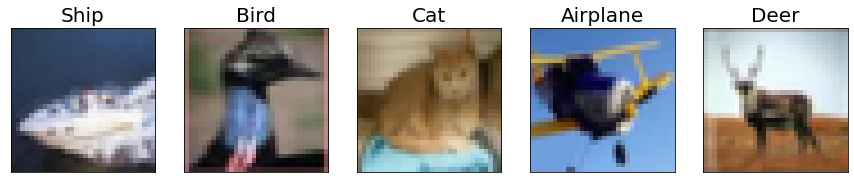

In [10]:
show_img(train_images, train_labels, 5)

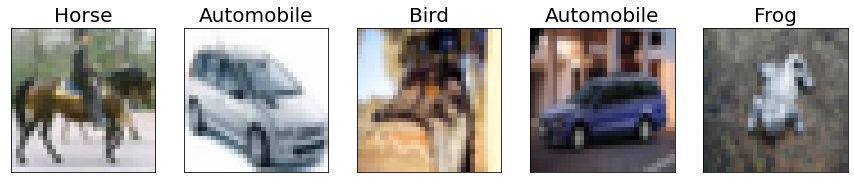

In [11]:
show_img(train_images, train_labels, 5)

### Saving images in respective folder

In [12]:
train_dir = './datasets/train/'
test_dir = './datasets/test/'

In [13]:
i = 0

for img, label in zip(train_images, train_labels):
    
    path = train_dir + str(lookup[int(label)])
    Path(path).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(os.path.join(path, str(i) + '.jpeg'), img)
    
    i += 1
    cv2.waitKey(0)

In [14]:
i = 0

for img, label in zip(test_images, test_labels):

    path = test_dir + str(lookup[int(label)])
    Path(path).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(os.path.join(path, str(i) + '.jpeg'), img)
 
    i += 1
    
    cv2.waitKey(0)

### Data Preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

* Read images from the disk.
* Decode contents of these images and convert it into proper grid format as per their RGB content.
* Convert them into floating point tensors.
* Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by tf.keras.

In [15]:
train_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

After defining the generators for training and validation images, the flow_from_directory method loads images from the disk, applies rescaling, and resizes the images into the required dimension. We haven't applied any data augmentation techniques here, we'll work with the images as is.

In [16]:
batch_size = 128

In [17]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(32, 32))

Found 50000 images belonging to 10 classes.


In [18]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=test_dir,
                                                         shuffle=True,
                                                         target_size=(32, 32))

Found 10000 images belonging to 10 classes.


In [26]:
sample_batch = next(train_data_gen)

sample_batch[0].shape

(128, 32, 32, 3)

### Building model

In [20]:
conv_model = tf.keras.models.Sequential([

    layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                  input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')

])

### Compile model

In [21]:
conv_model.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

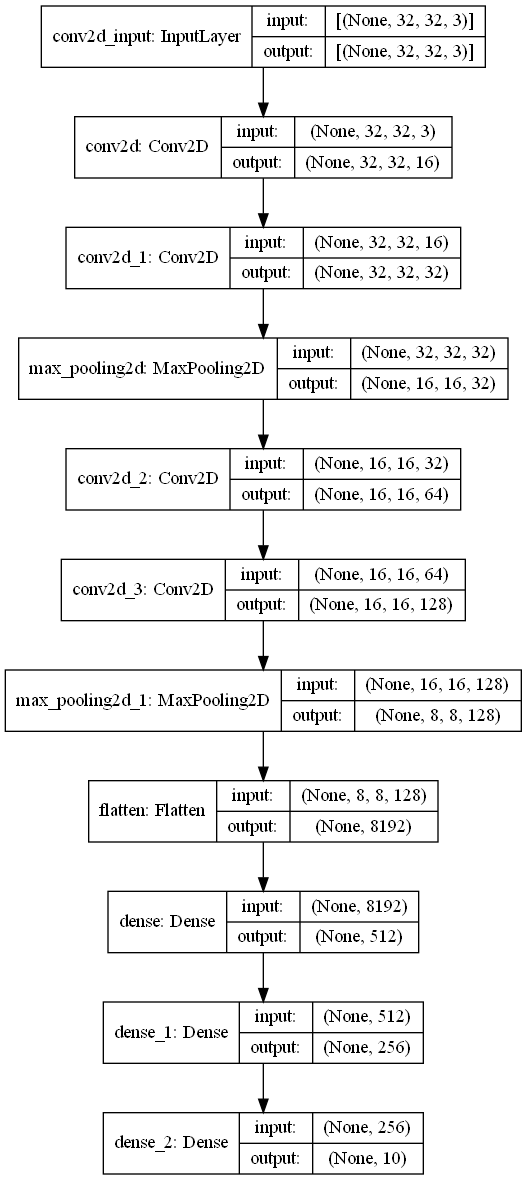

In [22]:
keras.utils.plot_model(conv_model, 'model_image_classification_shapes.png', show_shapes=True)

### Training model

In [31]:
training_hist = conv_model.fit(train_data_gen,
                               epochs=5,
                               steps_per_epoch=len(train_images) // batch_size,
                               validation_data=test_data_gen,
                               validation_steps=len(test_images) // batch_size)

Epoch 1/5
390/390 [==============================] - 490s 1s/step - loss: 1.3203 - accuracy: 0.5227 - val_loss: 1.1134 - val_accuracy: 0.6016
Epoch 2/5
390/390 [==============================] - 183s 469ms/step - loss: 0.9546 - accuracy: 0.6621 - val_loss: 0.9144 - val_accuracy: 0.6804
Epoch 3/5
390/390 [==============================] - 204s 524ms/step - loss: 0.7467 - accuracy: 0.7376 - val_loss: 0.8420 - val_accuracy: 0.7108
Epoch 4/5
390/390 [==============================] - 238s 610ms/step - loss: 0.5770 - accuracy: 0.7978 - val_loss: 0.8341 - val_accuracy: 0.7184
Epoch 5/5
390/390 [==============================] - 240s 614ms/step - loss: 0.4241 - accuracy: 0.8505 - val_loss: 0.8298 - val_accuracy: 0.7318


### Plotting accuracy and loss with epoch both for training and validation

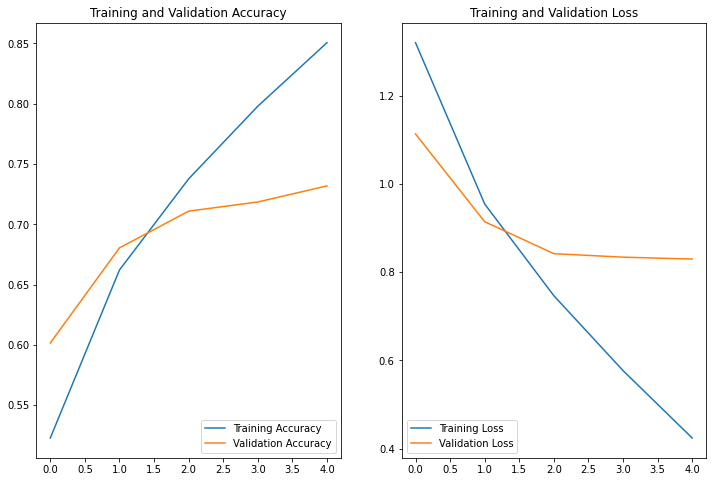

In [32]:
acc = training_hist.history['accuracy']
val_acc = training_hist.history['val_accuracy']

loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='lower left')

plt.title('Training and Validation Loss')
plt.show()

### Testing

#### Test 1:

In [33]:
from tensorflow.keras.preprocessing import image

In [34]:
test_images[0].shape

(32, 32, 3)

In [36]:
def perform_test(model, img, label):
    plt.imshow(img)
    
    test_img = np.expand_dims(img, axis=0)
    result = model.predict(test_img)
    
    print('Actual label: ', lookup[int(label)])
    print('Predicted label: ', lookup[np.argmax(result)])

Actual label:  Cat
Predicted label:  Cat


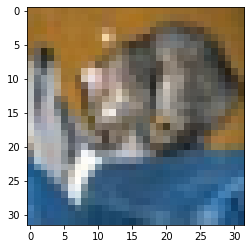

In [40]:
perform_test(conv_model, test_images[0], test_labels[0])

Actual label:  Ship
Predicted label:  Ship


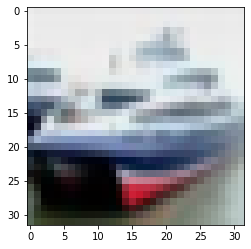

In [41]:
perform_test(conv_model, test_images[1], test_labels[1])

Actual label:  Airplane
Predicted label:  Ship


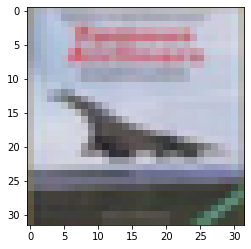

In [42]:
perform_test(conv_model, test_images[3], test_labels[3])

Actual label:  Automobile
Predicted label:  Truck


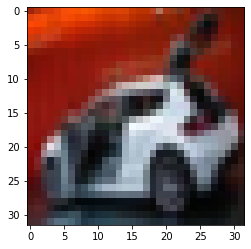

In [43]:
perform_test(conv_model, test_images[6], test_labels[6])

Found 50000 images belonging to 10 classes.


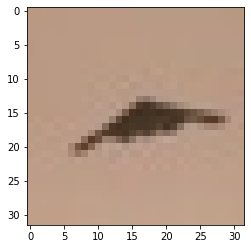

In [44]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(32, 32))


plt.imshow(train_data_gen[0][0][0])

Found 50000 images belonging to 10 classes.


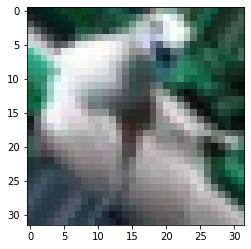

In [35]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=60)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(32, 32))

plt.imshow(train_data_gen[0][0][0])

Found 50000 images belonging to 10 classes.


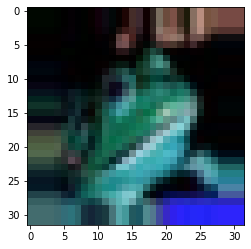

In [36]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(32, 32))

plt.imshow(train_data_gen[0][0][0])

Found 50000 images belonging to 10 classes.


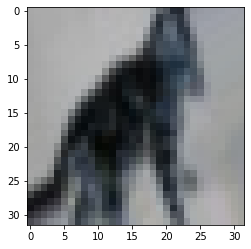

In [37]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=.05,
    height_shift_range=.05,
    horizontal_flip=True,
    zoom_range=0.3
)

train_data_gen_aug = image_gen.flow_from_directory(batch_size=batch_size,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(32, 32))

plt.imshow(train_data_gen_aug[0][0][0])

### Building model with dropout

In [38]:
conv_model_with_dropout = tf.keras.models.Sequential([

    layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                  input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Dropout(0.25),

    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    
    layers.Dropout(0.25),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')

])

In [39]:
conv_model_with_dropout.compile(optimizer='adam',
                                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                metrics=['accuracy'])

### Training model

In [40]:
training_hist = conv_model_with_dropout.fit(train_data_gen, 
                                            epochs=5,
                                            steps_per_epoch=len(train_images) // batch_size,
                                            validation_data=test_data_gen,
                                            validation_steps=len(test_images) // batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 390 steps, validate for 78 steps
Epoch 1/5
390/390 [==============================] - 189s 483ms/step - loss: 0.7220 - accuracy: 0.8818 - val_loss: 0.7115 - val_accuracy: 0.8894
Epoch 2/5
390/390 [==============================] - 177s 454ms/step - loss: 0.7124 - accuracy: 0.8890 - val_loss: 0.7061 - val_accuracy: 0.8987
Epoch 3/5
390/390 [==============================] - 192s 491ms/step - loss: 0.7086 - accuracy: 0.8952 - val_loss: 0.7017 - val_accuracy: 0.9086
Epoch 4/5
390/390 [==============================] - 184s 472ms/step - loss: 0.7059 - accuracy: 0.9001 - val_loss: 0.7017 - val_accuracy: 0.9074
Epoch 5/5
390/390 [==============================] - 185s 474ms/step - loss: 0.7032 - accuracy: 0.9050 - val_loss: 0.6989 - val_accuracy: 0.9128


### Plotting accuracy and loss with epoch for training and validation

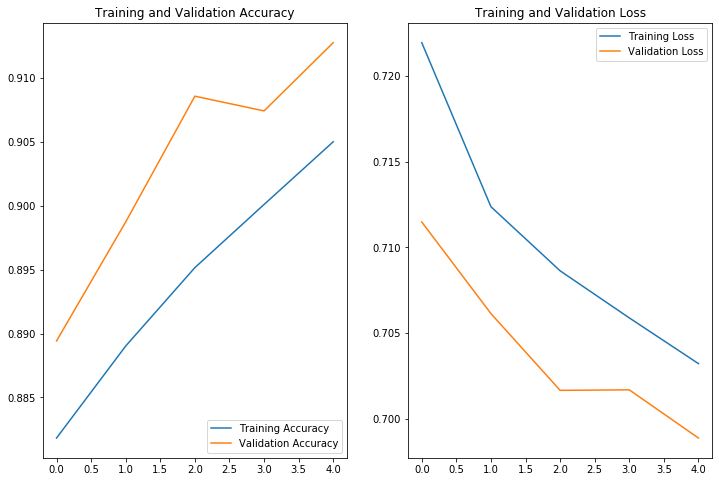

In [41]:
acc = training_hist.history['accuracy']
val_acc = training_hist.history['val_accuracy']

loss=training_hist.history['loss']
val_loss=training_hist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Actual label:  Ship
Predicted label:  Truck


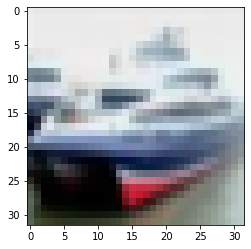

In [42]:
perform_test(conv_model_with_dropout, test_images[1], test_labels[1])

Actual label:  Airplane
Predicted label:  Airplane


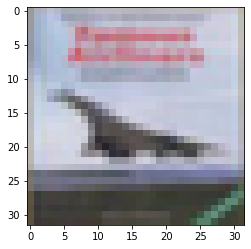

In [43]:
perform_test(conv_model_with_dropout, test_images[3], test_labels[3])

Actual label:  Airplane
Predicted label:  Airplane


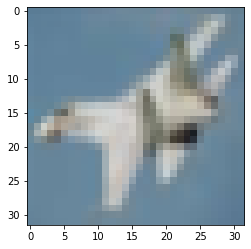

In [44]:
perform_test(conv_model_with_dropout, test_images[10], test_labels[10])

Actual label:  Deer
Predicted label:  Truck


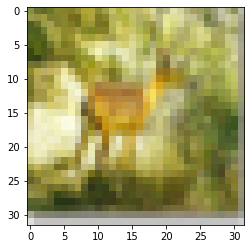

In [45]:
perform_test(conv_model_with_dropout, test_images[500], test_labels[500])

Actual label:  Dog
Predicted label:  Dog


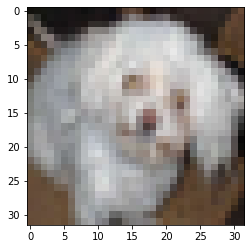

In [46]:
perform_test(conv_model_with_dropout, test_images[1000], test_labels[1000])

Actual label:  Automobile
Predicted label:  Automobile


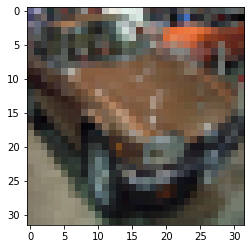

In [47]:
perform_test(conv_model_with_dropout, test_images[2000], test_labels[2000])